In [18]:
from analyse_helper import load_ocelot_data
import numpy as np
import matplotlib.pyplot as plt
import json
import glob
import torch
from botorch.fit import fit_gpytorch_model
from botorch.models import SingleTaskGP
from botorch.models.transforms import Normalize, Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood

BASE_DIR = "../2022-11-24-data/"

In [118]:
# IPAC PLOT SIZES
TEXTWIDTH = 483.69684
LINEWIDTH = 214.7352
#pt_to_inches = 1/72.27
fig_width_pt = TEXTWIDTH
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]

 
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
#plt.rc('xtick', labelsize=8)
#plt.rc('ytick', labelsize=8)
#plt.rc('axes', labelsize=8)

params = {'axes.titlesize': 8,
          'axes.labelsize': 8,
          'legend.fontsize': 8,
          'xtick.labelsize': 6,
          'ytick.labelsize': 6,
          'figure.figsize': fig_size}
plt.rcParams.update(params)

## Look into the 4d optimization data

In [4]:
with open(BASE_DIR+"/bo/benchmark_ucb_2022_11_24-09_11_00.json", "r") as f:
    data = json.load(f)

In [24]:
X = np.array(data["X"])
Y = np.array(data["Y"])
print(X.shape, Y.shape)
print("Min", np.min(X,axis=0))
print("Max", np.max(X,axis=0))
print(X[np.argmax(Y)])
print("Mean", np.mean(X, axis=0))

(56, 4) (56,)
Min [ 2.13730189e-05 -1.43588687e-02 -6.78212494e-02 -2.55248964e-01]
Max [0.11032136 0.06095994 0.16175783 0.09440861]
[0.00237895 0.05838207 0.15619454 0.01294369]
Mean [0.02025177 0.04396096 0.11443921 0.00303102]


In [19]:
gp = SingleTaskGP(
                train_X=torch.tensor(X),
                train_Y=torch.tensor(Y).reshape(-1,1),
                outcome_transform=Standardize(1),
                input_transform=Normalize(X.shape[1]),
            )
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_model(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
        (distance_module): Distance()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
    (outcome_transform): Standardize()
    (input_transform): Normalize()
  )
)

In [116]:
gp.mean_module.constant

Parameter containing:
tensor(-1.3478, dtype=torch.float64, requires_grad=True)

In [94]:
xmin, xmax = -0.25, 0.25
n_points = 50
ndim = 4
mean_values = np.mean(X, axis=0)
xlist = np.linspace(xmin, xmax, n_points)
ylist = np.linspace(xmin, xmax, n_points)
XX, YY = np.meshgrid(xlist,ylist)

inputs = torch.zeros(n_points**2, ndim)
inputs[:] = torch.tensor(mean_values)
zvalues = np.zeros((4,4,n_points,n_points))
for i in range(4):
    for j in range(4):
        input_copy = torch.clone(inputs.detach())
        input_copy[:,i] = torch.tensor(XX.flatten())
        input_copy[:,j] = torch.tensor(YY.flatten())
        prediction = gp.posterior(input_copy)
        ZZ = prediction.mean.detach().numpy().reshape(n_points,n_points)
        zvalues[i,j] = ZZ
# inputs[:,1] = torch.tensor(XX.flatten())
# inputs[:,3] = torch.tensor(YY.flatten())
# inputs[:,0] = mean_values[0]
# inputs[:,1] = mean_values[1]
# inputs[:,2] = mean_values[2]
# inputs[:,3] = mean_values[3]

# prediction = gp.posterior(inputs)
# ZZ = prediction.mean.detach().numpy().reshape(n_points,n_points)

In [ ]:
plt.hist()

<BarContainer object of 10 artists>

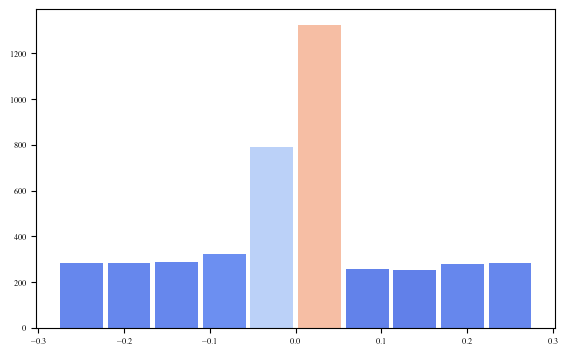

In [192]:
# plt.imshow(ZZ)
# i, j = 0, 1
# plt.pcolormesh(XX,YY, zvalues[2,3], shading="gouraud")
# plt.colorbar()
n_bins = 10
histinputs = torch.zeros(n_bins, ndim)
histinputs[:,] = torch.tensor(mean_values)
x_histlist = torch.linspace(xmin, xmax, n_bins)
dx = (xmax-xmin)/ n_bins
my_cmap = plt.get_cmap("coolwarm")
vmax = np.max(zvalues)
vmin = 0
rescale_color = lambda y: (y - vmin) / (vmax - vmin)
y_hist_values = np.zeros((4,n_bins))
for i in range(4):
    input_copy = histinputs.clone().detach()
    input_copy[:,i] = x_histlist
    y_hist_values[i] = gp.posterior(input_copy).mean.detach().numpy().flatten()

plt.bar(x_histlist, y_hist_values[0], color=my_cmap(rescale_color(y_hist_values[0])), width = dx,)

In [193]:
y_histvalues

array([ 285.48976476,  285.75543233,  297.32804268,  646.44963569,
       1050.07485513,  226.72641682,  276.4716366 ,  284.96327134])

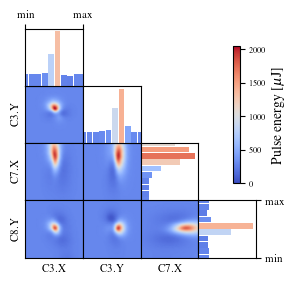

In [215]:
fig = plt.figure(figsize=(LINEWIDTH*inches_per_pt, LINEWIDTH*inches_per_pt*1))
gs = fig.add_gridspec(4,4)

ax03 = fig.add_subplot(gs[1,0])
ax02 = fig.add_subplot(gs[2,0])
ax01 = fig.add_subplot(gs[3,0])
ax13 = fig.add_subplot(gs[2,1])
ax12 = fig.add_subplot(gs[3,1])
ax23 = fig.add_subplot(gs[3,2])
ax_hist1 = fig.add_subplot(gs[0,0])
ax_hist2 = fig.add_subplot(gs[1,1])
ax_hist3 = fig.add_subplot(gs[2,2])
ax_hist4 = fig.add_subplot(gs[3,3])
ax_colorbar = fig.add_subplot(gs[:3,3])
for ax in [ax_hist2, ax_hist3, ax_hist4, ax02, ax03, ax13]:
    ax.get_xaxis().set_visible(False)
for ax in [ax_hist1, ax_hist2, ax_hist3, ax12, ax13, ax23]:
    ax.get_yaxis().set_visible(False)
for ax in [ax01, ax12, ax23]:
    ax.set_xticks([])
for ax in [ax01,ax02,ax03]:
    ax.set_yticks([])

# Posterior mean plots
vmax = np.max(zvalues)
vmin = 0
cmap = "coolwarm"
im = ax03.pcolormesh(XX, YY, zvalues[0,1], shading="gouraud", vmax=vmax, vmin=vmin, cmap=cmap)
ax02.pcolormesh(XX, YY, zvalues[0,2], shading="gouraud", vmax=vmax, vmin=vmin, cmap=cmap)
ax01.pcolormesh(XX, YY, zvalues[0,3], shading="gouraud", vmax=vmax, vmin=vmin, cmap=cmap)
ax13.pcolormesh(XX, YY, zvalues[1,2], shading="gouraud", vmax=vmax, vmin=vmin, cmap=cmap)
ax12.pcolormesh(XX, YY, zvalues[1,3], shading="gouraud", vmax=vmax, vmin=vmin, cmap=cmap)
ax23.pcolormesh(XX, YY, zvalues[2,3], shading="gouraud", vmax=vmax, vmin=vmin, cmap=cmap)

# histogram
ax_hist1.bar(x_histlist, y_hist_values[0], color=my_cmap(rescale_color(y_hist_values[0])), width = dx)
# ax_hist1.plot(x_histlist,y_hist_values[0])
ax_hist2.bar(x_histlist, y_hist_values[1], color=my_cmap(rescale_color(y_hist_values[1])), width = dx)
ax_hist3.barh(x_histlist, y_hist_values[2], color=my_cmap(rescale_color(y_hist_values[2])), height = dx)
ax_hist4.barh(x_histlist, y_hist_values[3], color=my_cmap(rescale_color(y_hist_values[3])), height = dx)

ax_hist1.set_xlim(xmin, xmax)
ax_hist2.set_xlim(xmin, xmax)
ax_hist3.set_ylim(xmin, xmax)
ax_hist4.set_ylim(xmin, xmax)
# colorbar
cbar = fig.colorbar(im, ax=ax_colorbar, fraction=0.4, shrink=0.8)
cbar.set_label(r"Pulse energy [$\mathrm{\mu}$J]")
ax_colorbar.set_axis_off()
# axis labels
ax_hist1.xaxis.tick_top()
ax_hist1.set_xticks([xmin,xmax])
ax_hist1.set_xticklabels(["min","max"], fontsize=8)
ax_hist4.yaxis.tick_right()
ax_hist4.set_yticks([xmin,xmax])
ax_hist4.set_yticklabels(["min","max"], fontsize=8)
ax01.set_xlabel("C3.X", fontsize=8)
ax12.set_xlabel("C3.Y", fontsize=8)
ax23.set_xlabel("C7.X", fontsize=8)

ax01.set_ylabel("C8.Y", fontsize=8)
ax02.set_ylabel("C7.X", fontsize=8)
ax03.set_ylabel("C3.Y", fontsize=8)
fig.subplots_adjust(hspace=0, wspace=0)
# fig.savefig("../plots/posterior_space.pdf", dpi=300, bbox_inches="tight")